In [5]:
%%capture
#Suppress install output


#INSTALLS & IMPORTS
!pip install pytrends
!pip install lingua-language-detector
!pip install openpyxl
!pip install seaborn
!pip install scipy

import scipy.stats as stats                                           
import warnings                                                       
import pandas as pd                                                     
import numpy as np                                                  
import re                                                             
from lingua import Language, LanguageDetectorBuilder                 
from pytrends.request import TrendReq                                    
from datetime import datetime                                              
import seaborn as sns                                                      
import matplotlib.pyplot as plt                                            

warnings.simplefilter(action='ignore', category=FutureWarning)                                   #Removes futurewarning whenever code is run
pd.set_option('display.max_rows', None)                                                          #Pandas row options
pd.set_option('max_colwidth', 1000)                                                              #Pandas column options
detector = LanguageDetectorBuilder.from_languages(Language.ENGLISH,Language.INDONESIAN).build()  #Build detector with English & Indonesian

Text(0.5, 1.0, 'Paper Topic Breakdown (2015-2023)')

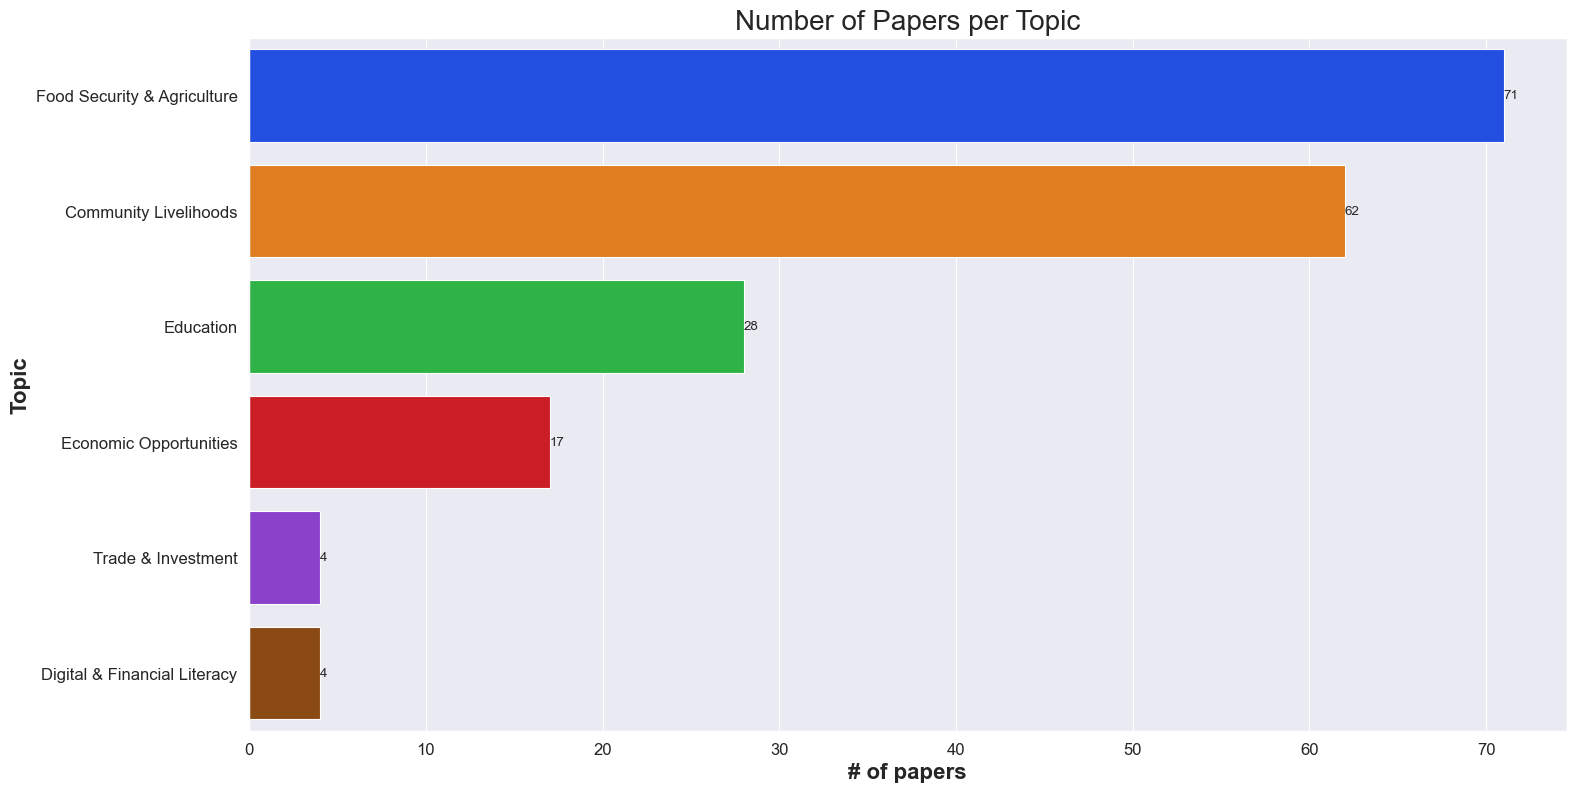

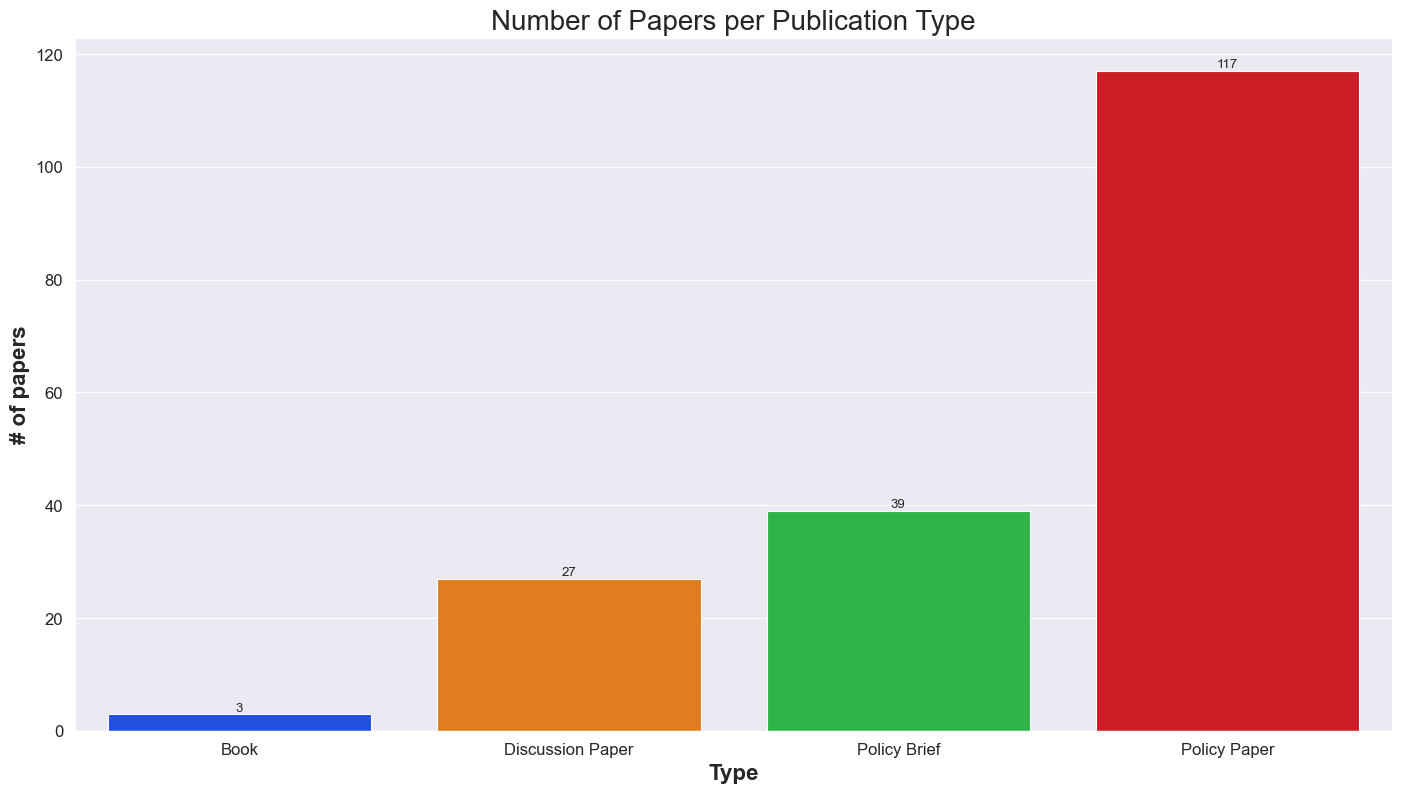

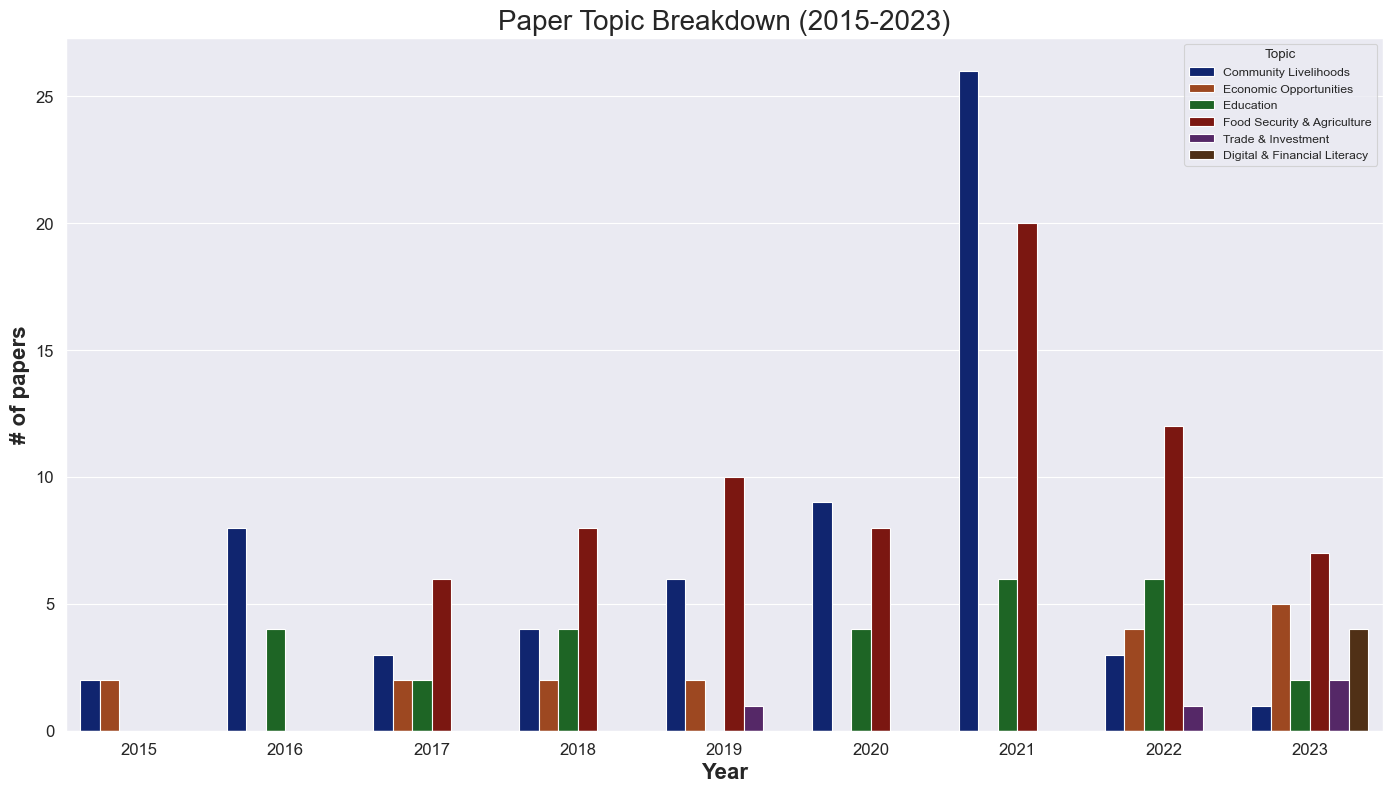

In [23]:
#PUBLICATION CHARACTERISTICS DATABASE CLEANING & VISUALISATION

#Import publication characteristic databases
book_titles = pd.read_csv("Databases/Publication_Databases/Book_Titles.csv",header=1)
discpap_titles = pd.read_csv("Databases/Publication_Databases/Discussion_Paper_Titles.csv")
brief_titles = pd.read_csv("Databases/Publication_Databases/Policy_Brief_Titles.csv")
polpap_titles = pd.read_csv("Databases/Publication_Databases/Policy_Paper_Titles.csv")

#Define function for cleaning and unionising columns
def columnsna(df):
    
    #Drop columns if not part of thelist
    thelist = ['Title','Type','Topic','Year','Language Page','Author','Keywords','Authors']
    for col in df.columns.tolist():
        if col not in thelist:
            df = df.drop(col,axis=1)

    #Match database column order and label to each database
    if 'Authors' in df.columns.tolist():
        df = df.reindex(columns=['Title','Type','Topic','Year','Language Page','Authors','Keywords'])
        df.rename(columns={'Authors':'Author','Language Page':'Language'},inplace=True)
    elif 'Authors' not in df.columns.tolist():
        df = df.reindex(columns=['Title','Type','Topic','Year','Language Page','Author','Keywords'])
        df.rename(columns={'Language Page':'Language'},inplace=True)

    #Drop rows with no publication title and reset index
    df.dropna(axis=0,subset='Title',inplace=True)
    df.reset_index(inplace=True,drop=True)
    
    return df

#Define database formatting function
def formatting(df):

    #Fill empty values with '-' and remove spaces from all columns except the 'Year' column
    df.fillna('-',inplace=True)
    for col in df.columns.tolist():
        if col != 'Year':
            df[col] = df[col].str.strip()

    #Regex pattern looks for a 4 digit year anywhere in the string and keywordlang is for the detected language of the keyword column
    pattern = r'\b\d{4}\b'
    keywordlang = []
    for row in df.itertuples():
        
        #Match returns None if no 4 digit year is found. If found, sets the year value to the 4 digit year (removes month and slashes)
        match = re.search(pattern,str(row[4]))
        if match != None:
            df.loc[row[0],'Year'] = int(match.group())

        #Unifies Indonesian label
        if 'Indonesia' in str(row[5]):
            df.loc[row[0],'Language'] = 'Indonesian'

        #Detects language of keyword column and appends it to keywordlang. Appends '-' if no value in keyword column
        if row[7] != '-':
            keywordlang.append(str(detector.detect_language_of(str(row[7]))).replace('Language.','').title())
        elif row[7] == '-':
            keywordlang.append('-')
            
    df['Keyword Language'] = keywordlang
    
    return df

#Applies the column function to all publication databases
polpap_titles = columnsna(polpap_titles)
book_titles = columnsna(book_titles)
discpap_titles = columnsna(discpap_titles)
brief_titles = columnsna(brief_titles)

#Sets the type columns in databases without one
polpap_titles['Type'] = 'Policy Paper'
discpap_titles['Type'] = 'Discussion Paper'
brief_titles['Type'] = 'Policy Brief'

#Master database contains formatted versions of each database sorted by 'Type' with a unified index
pubs = pd.concat([formatting(book_titles),formatting(discpap_titles),formatting(brief_titles),formatting(polpap_titles)],axis=0)
pubs.sort_values(by='Type',ascending=True,inplace=True)
pubs.reset_index(drop=True,inplace=True)

#Unifies year column type and values for years skipped in formatting or missing (looked up release year on website)
pubs.loc[pubs['Year'] == 'Dec/22','Year'] = 2022
pubs.loc[115,'Year'] = 2022
pubs['Year'] = pubs['Year'].astype('int32')

#Removes '\n' from the 'Title', 'Keywords', and 'Author' columns
pubs['Title'] = pubs['Title'].str.replace('\n',' ')
pubs['Keywords'] = pubs['Keywords'].str.replace('\n',' ')
pubs['Author'] = pubs['Author'].str.replace('\n',' ')

#Fixes inaccurate or missing entries in the 'Title','Language', and 'Keyword Language' columns. Missing data was completed by checking the website
pubs.loc[18,'Title'] = 'Improving Indonesia’s Food Statistics through the Area Sampling Frame Method'
pubs.loc[[3,13,15,30,32,35,165,166],'Language'] = 'English'
pubs.loc[[12,14,39,47,101,113],'Language'] = 'Indonesian'
pubs.loc[[27,90,163,169],'Keyword Language'] = 'English'

#Re-values 'Topic' to be one of 5 options: 'Community Livelihoods', 'Economic Opportunities', 'Food Security & Agriculture', 'Trade & Investment', 'Digital & Financial Literacy', and 'Education'
pubs.loc[[12,13],'Topic'] = 'Education'
pubs.loc[[14,15],'Topic'] = 'Community Livelihoods'
pubs.loc[[35,37,42,43,44,115],'Topic'] = 'Economic Opportunities'
pubs.loc[[36,41,99,107,185],'Topic'] = 'Food Security & Agriculture'
pubs.loc[pubs['Topic'] == 'Kesejahteraan Rakyat','Topic'] = 'Community Livelihoods'
pubs.loc[pubs['Topic'] == 'Ketahanan Pangan & Agrikultur','Topic'] = 'Food Security & Agriculture'
pubs.loc[pubs['Topic'] == 'Pendidikan','Topic'] = 'Education'
pubs.loc[pubs['Topic'] == 'Food Trade & Agriculture','Topic'] = 'Food Security & Agriculture'
pubs.loc[pubs['Topic'] == 'Agriculture, Food Security and Nutrition, Trade and Investment','Topic'] = 'Food Security & Agriculture'
pubs.loc[pubs['Topic'] == 'Kesempatan Berusaha','Topic'] = 'Economic Opportunities'
pubs.loc[pubs['Topic'] == 'Ekonomi Digital, Perlindungan Konsumen, Literasi Digital dan Keuangan','Topic'] = 'Digital & Financial Literacy'
pubs.loc[pubs['Topic'] == 'Digital Economy, Consumer Protection, Digital and Financial Literacy','Topic'] = 'Digital & Financial Literacy'
pubs.loc[pubs['Topic'] == 'Educations','Topic'] = 'Education'
pubs.loc[pubs['Topic'] == 'Pendidikan, Peluang Ekonomi dan Kewirausahaan, Perdagangan dan Investasi','Topic'] = 'Education'
pubs.loc[pubs['Topic'] == 'Pertanian, Kehutanan dan Penggunaan Lahan','Topic'] = 'Community Livelihoods'
pubs.loc[pubs['Topic'] == 'General','Topic'] = 'Trade & Investment'
pubs.loc[pubs['Topic'] == 'Agriculture,','Topic'] = 'Economic Opportunities'
pubs.loc[pubs['Topic'] == 'Agriculture,Food Security and Nutrition, Trade and Investment','Topic'] = 'Trade & Investment'
pubs.loc[pubs['Topic'] == 'Education, School Management, Covid-19 Response','Topic'] = 'Education'
pubs.loc[pubs['Topic'] == 'Education, Entrepreneurship and Economic Opportunities, Trade and Investment','Topic'] = 'Education'
pubs.loc[pubs['Topic'] == 'Pendidikan, Pengelolaan Sekolah, Respon Covid-19','Topic'] = 'Education'
pubs.loc[pubs['Topic'] == 'Agriculture, Forestry and Land Use','Topic'] = 'Food Security & Agriculture'
pubs.loc[pubs['Topic'] == 'Peluang Ekonomi dan Kewirausahaan, Perdagangan dan Investasi, Ketahanan Pangan dan Nutrisi','Topic'] = 'Trade & Investment'
pubs.loc[pubs['Topic'] == 'Trade and Investment, Enterpreneurship and Economic Opportunities, Food Security and Nutrition','Topic'] = 'Trade & Investment'
pubs.loc[pubs['Topic'] == 'Kesejateraan Rakyat','Topic'] = 'Community Livelihoods'
pubs.loc[pubs['Topic'] == 'Kesempatan Ekonomi','Topic'] = 'Economic Opportunities'

#TOPIC COUNTPLOT
plt.figure(figsize=(17,9))
ax = sns.countplot(data=pubs[['Topic']],y='Topic',orient='h',palette='bright',width=0.8,
                   order=['Food Security & Agriculture','Community Livelihoods','Education','Economic Opportunities','Trade & Investment','Digital & Financial Literacy'])
for label in ax.containers:
    ax.bar_label(label)
plt.xlabel('# of papers',fontsize=16,fontweight='bold')
plt.ylabel('Topic',fontsize=16,fontweight='bold')
plt.title('Number of Papers per Topic')

#TYPE COUNTPLOT
plt.figure(figsize=(17,9))
ax = sns.countplot(data=pubs[['Type']],x='Type',palette='bright',width=0.8)
for label in ax.containers:
    ax.bar_label(label)
plt.xlabel('Type',fontsize=16,fontweight='bold')
plt.ylabel('# of papers',fontsize=16,fontweight='bold')
plt.title('Number of Papers per Publication Type')

#TOPICS PER YEAR COUNTPLOT
sns.set_style('darkgrid')
plt.figure(figsize=(17,9))
sns.countplot(data=pubs[['Year','Topic']],x='Year',hue='Topic')
plt.xlabel('Year',fontsize=16,fontweight='bold')
plt.ylabel('# of papers',fontsize=16,fontweight='bold')
plt.title('Paper Topic Breakdown (2015-2023)')

In [20]:
#CLICK DATABASE CREATION FROM TWO DATA SOURCES

#Import click data from two sources
raw_web = pd.read_excel("Databases/Digital_Media_Dashboard.xlsm",sheet_name='Paper_Views_Downloads',header=3)
raw_neliti = pd.read_excel("Databases/Digital_Media_Dashboard.xlsm",sheet_name='Paper_Neliti',header=3)

#Define function to wrangle click data
def wrangle(df):

    #Drops irrelevant columns where the if statement is used to specify the source dataset
    if 'Code' in df.columns.tolist():
        df.drop(['Code','Date Published\n(dd/mm/yy)','No'],axis=1,inplace=True)
    elif 'Date Published\n(mm/yy)' in df.columns.tolist():
        df.drop(['Date Published\n(mm/yy)','No'],axis=1,inplace=True)

    #Drops first row (irrelevant summation row), fills empty values with 0 and resets the index
    df.drop(0,axis=0,inplace=True)
    df.fillna(0,inplace=True)
    df.reset_index(drop=True,inplace=True)

    #Datetime column headers in both datasets are the starts of every month. Each month has several columns for different click types and languages.
    #Indexes of the datetime header columns are used to perform operations on all different columns in each month
    posdatetimes = [index for index,x in enumerate(df.columns.tolist()) if type(x) is datetime]

    #Column headers with a type of integer represent the year's totals. 
    headerdates = []
    for x in df.columns.tolist():

        #If the column header is of the datetime type, appends duplicates of the datetime as a string in the format '2022_Jan_'.
        #The number of duplicates is determined by the number of columns between each month
        if type(x) is datetime:
            add = [x.strftime("%Y_%b_")] * (posdatetimes[1]-posdatetimes[0])
            headerdates.append(add)

        #Does the same for the year columns but has an additional 'and' statement to specify the dataset as the number of columns between the year column and the next month column differ
        elif type(x) is int and df.iloc[0,1] == 'EN(D)':
            add = [str(x)+'_'] * 7
            headerdates.append(add)
        elif type(x) is int and df.iloc[0,1] == 'Neliti':
            add = [str(x)+'_'] * 5
            headerdates.append(add)

    #Flattens 'headerdates' and adds the column's click type and language found in the first row of each dataset to the string. Skips the first column containing the publication titles
    headers = [[i for x in headerdates for i in x][index]+x for index,x in enumerate(df.loc[0][1:].tolist())]

    #Reformats the click type and language for readability
    headers = [x.replace('EN(D)','ENG_DL') if 'EN(D)' in x else 
               x.replace('EN(V)','ENG_VIEW') if 'EN(V)' in x else 
               x.replace('INA(D)','IND_DL') if 'INA(D)' in x else 
               x.replace('INA(V)','IND_VIEW') if 'INA(V)' in x else
               x.replace('EN View','TOTAL_ENG_VIEW') if 'EN View' in x else
               x.replace('INA View','TOTAL_IND_VIEW') if 'INA View' in x else
               x.replace('EN Download','TOTAL_ENG_DL') if 'EN Download' in x else
               x.replace('INA Download','TOTAL_IND_DL') if 'INA Download' in x else
               x.replace('View & Download','TOTAL_ALL') if 'View & Download' in x else
               x
               for x in headers]

    #Replaces the database headers with the newly generated 'headers' list and drops the first row containing the language and click type
    df.columns.values[1:] = headers
    df.drop(0,axis=0,inplace=True)

    #Each if statement returns the irrelevant datatype columns from both datasets then drops them. Resulting columns only include download & view data for both languages
    if df.columns.tolist()[1] == '2019_Jan_Neliti':
        nelindex = [index for index,x in enumerate(df.columns.tolist()) if 'neliti' in str(x).lower() or 'total' in str(x).lower()]
        df.drop(df.columns[nelindex],axis=1,inplace=True)    
    elif df.columns.tolist()[1] == '2019_Jan_ENG_DL':
        tmsindex = [index for index,x in enumerate(df.columns.tolist()) if 'tms' in str(x).lower() or 'total' in str(x).lower()]
        df.drop(df.columns[tmsindex],axis=1,inplace=True)

    #Removes '\n' from the 'Title' column and resets the index
    df['Title'] = df['Title'].str.replace('\n',' ')
    df.reset_index(drop=True,inplace=True)

    #Returns a final list where all the data columns are converted to integers
    final = pd.concat([df.iloc[:,0],df.iloc[:,1:].astype('int')],axis=1)
        
    return final

#Define function to append the publication 'Type' and 'Topic' to the click data from the characteristics database
#frame_source = 'Neliti' OR 'Website'
def add_type_add_topic(frame,frame_source):

    #Returns a lowercase, '_' separated list of publication titles from the characteristics database
    all_pub_titles = pubs['Title'].str.lower().str.replace(' ','_').tolist()

    #Initialize empty type and topic lists for appending and loops through the dataframe
    type_list = []
    topic_list = []
    for row in frame.itertuples():

        #Appends the appropriate 'Type' and 'Topic' from the characteristics database if there is a 'Title' match
        if str(row[1]).lower().replace(' ','_') in all_pub_titles:
            type_list.append(pubs.iloc[all_pub_titles.index(str(row[1]).lower().replace(' ','_')),1])
            topic_list.append(pubs.iloc[all_pub_titles.index(str(row[1]).lower().replace(' ','_')),2])

        #Appends '-' if there is no match
        elif str(row[1]).lower().replace(' ','_') not in all_pub_titles:
            type_list.append('-')
            topic_list.append('-')

    #Final dataframe has the columns in the correct order with all the categorical columns preceding the data columns. Also strips blank spaces from the 'Title' column
    final = pd.concat([pd.DataFrame({'Source':[frame_source] * len(frame)}),frame.loc[:,'Title'],pd.DataFrame({'Type':type_list,'Topic':topic_list}),frame.iloc[:,1:]],axis=1)
    final['Title'] = final['Title'].str.strip()
    
    return final

#Wrangles both click databases
neliti = wrangle(raw_neliti)
website = wrangle(raw_web)
website = website.reindex(columns = neliti.columns.tolist())

#Concatenates data sources with appended 'Type' and 'Topic' then sorts and resets index
clicks = pd.concat([add_type_add_topic(neliti,'Neliti'),add_type_add_topic(website,'Website')],axis=0)
clicks.sort_values(by='Title',inplace=True)
clicks.reset_index(drop=True,inplace=True)

#Adds missing/incorrect types and topics
clicks.loc[[2,3,4,5,41,46,49,50,63,64,73,74,79,80,85,86,112,117,118,126,
           133,138,139,148,149,153,161,162,164,167,168,177,178,185,186,188,
           206,207,223,230,231,263,266,267,297,302,303,307,308,311,312,
           322,323,326,327,334,341,342],'Type'] = 'Policy Paper'
clicks.loc[[83,84,109,123,129,169,170,208,268,269,272,279,280,309,310,343,344],'Type'] = 'Discussion Paper'
clicks.loc[[30,31,39,40,69,70,102,103,130,131,140,141,204,205,211,
           219,220,248,249,254,270,271,324,325],'Type'] = 'Policy Brief'
clicks.loc[[156],'Type'] = 'Book'
clicks.loc[[46,49,50,73,74,112,138,148,149,161,162,167,170,206,207,223,248,249,266,270,271,279,280,302],'Topic'] = 'Community Livelihoods'
clicks.loc[[63,64,79,80,83,84,130,131,156,164,188,263,268,269,303,307,308,322,323],'Topic'] = 'Food Security & Agriculture'
clicks.loc[[2,3,4,5,30,31,211,254,297,324,325],'Topic'] = 'Education'
clicks.loc[[41,85,86,133,185,186,230,231,334,343,344],'Topic'] = 'Economic Opportunities'

#Removes annual and financial reports then resets index
clicks.drop([14,32,33,34,35,36,199],axis=0,inplace=True)
clicks.reset_index(drop=True,inplace=True)

In [31]:
#CLICK DATA SUBSETTING AND TRANSFORMING (WIDE -> LONG)

#Define function for data subsetting
#Lang = (ENG or IND), Datatype = (VIEW or DL)
def df_subset(df,lang,datatype):

    #Returns a subset of columns with the specified 'Language' and 'Data Type' specified as parameters in the function. The columns are then used to return a subsetted dataframe
    col_subset = ['Source','Title','Type','Topic']+[x for x in df.columns.tolist() if lang in x and datatype in x]
    df_subset = df.loc[:,col_subset]

    #Adds categorical columns for the specified 'Language' and 'Data Type'
    if lang == 'ENG' and datatype == 'VIEW':
        df_subset['Language'] = 'English'
        df_subset['Click Type'] = 'View'
    elif lang == 'ENG' and datatype == 'DL':
        df_subset['Language'] = 'English'
        df_subset['Click Type'] = 'Download'
    elif lang == 'IND' and datatype == 'VIEW':
        df_subset['Language'] = 'Indonesian'
        df_subset['Click Type'] = 'View'
    elif lang == 'IND' and datatype == 'DL':
        df_subset['Language'] = 'Indonesian'
        df_subset['Click Type'] = 'Download'

    #Returns a correctly ordered subsetted dataframe with all categorical columns before the data
    final = pd.concat([df_subset.loc[:,['Source','Click Type','Language','Title','Type','Topic']],df_subset.iloc[:,4:-2]],axis=1)
    
    return final

#Define function for transforming data from wide to long format
def transform(df):

    #Initialise an empty dataframe with the necessary columns
    plot_df = pd.DataFrame(columns=['Source','Click Type','Language','Title','Type','Topic','Date','# of hits (thousands)'])
    
    for index,row in df.iterrows():
        #Each loop creates a dataframe with the publication's data in long form. Data ends at September 2023
        t = pd.DataFrame({'Source':df.iloc[index,0],'Click Type':df.iloc[index,1],'Language':df.iloc[index,2],
                          'Title':df.iloc[index,3],'Type':df.iloc[index,4],'Topic':df.iloc[index,5],
                          'Date':pd.date_range(start='2019-01-01',end='2023-09-01',freq='M'),
                          '# of hits (thousands)':df.iloc[index,6:62].tolist()})

        #The created dataframe is then appended to plot_df to create a running list of long formatted data
        plot_df = pd.concat([plot_df,t],axis=0,ignore_index=True)
    
    return plot_df

#Creates subsetted dataframes with differing 'Language' and 'Data Type'
eng_DL = df_subset(df=clicks,lang='ENG',datatype='DL')
eng_VIEWS = df_subset(df=clicks,lang='ENG',datatype='VIEW')
ind_DL = df_subset(df=clicks,lang='IND',datatype='DL')
ind_VIEWS = df_subset(df=clicks,lang='IND',datatype='VIEW')

#Creates a long form aggregate click database by running the transform function on each subsetted data
long_clicks = pd.concat([transform(eng_DL),transform(eng_VIEWS),transform(ind_DL),transform(ind_VIEWS)],axis=0,ignore_index=True)

Text(0.5, 1.0, 'Website Interest over Time (Downloads)')

<Figure size 400x400 with 0 Axes>

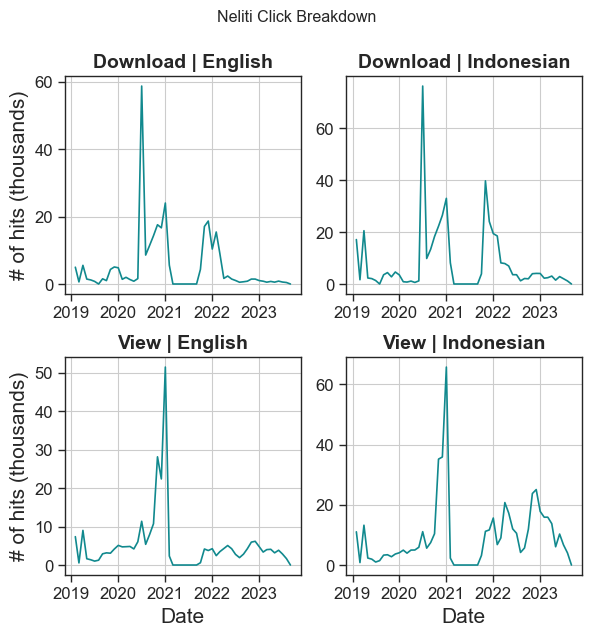

<Figure size 400x400 with 0 Axes>

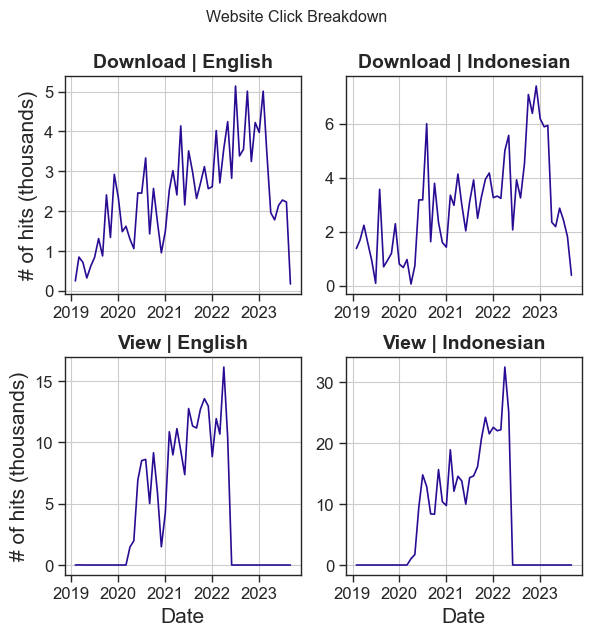

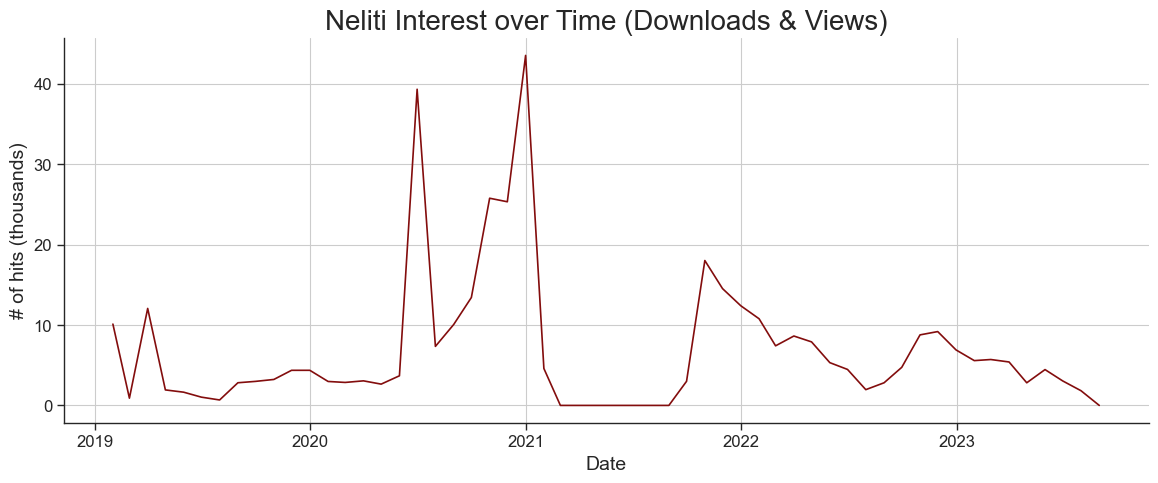

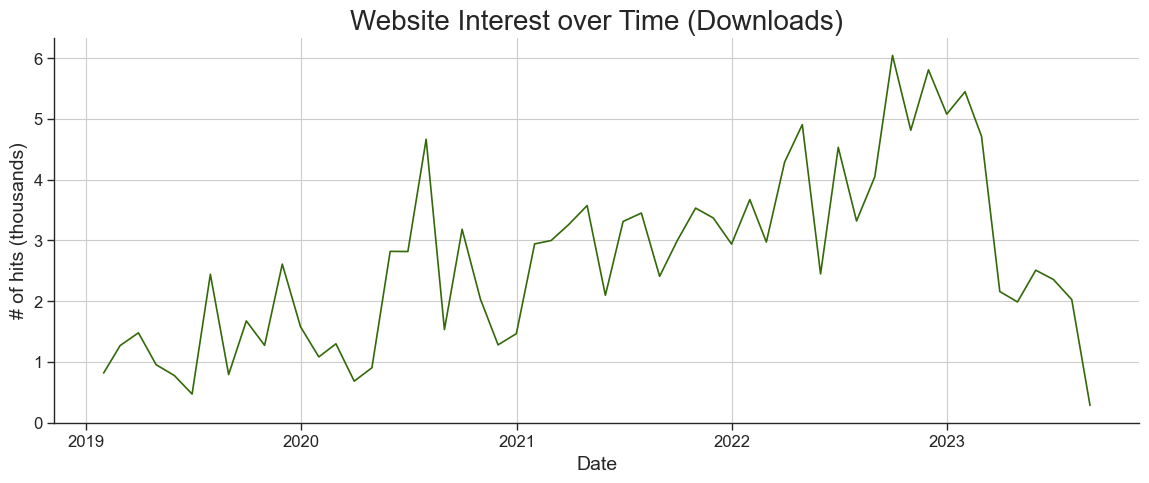

In [32]:
#CLICK DATA VISUALISATIONS

#FACETGRID - CLICK SOURCE 1
plt.figure(figsize=(4,4))
sns.set_style('ticks',{'axes.grid':True})
graph1 = sns.FacetGrid(long_clicks.loc[long_clicks['Source'] == 'Neliti'],col='Language',row='Click Type',sharex=False,sharey=False)
graph1.map(sns.lineplot,'Date','# of hits (thousands)',ci=None,color='#11898E')
graph1.set_titles(row_template='{row_name}',col_template='{col_name}',fontdict={'size':'35','weight':'bold'})
graph1.set_xlabels(fontdict={'size': 15})
graph1.set_ylabels(fontdict={'size':15})
sns.despine(top=False,right=False)
graph1.fig.suptitle('Neliti Click Breakdown',y=1.05)

#FACETGRID - CLICK SOURCE 2
plt.figure(figsize=(4,4))
sns.set_style('ticks',{'axes.grid':True})
graph2 = sns.FacetGrid(long_clicks.loc[long_clicks['Source'] == 'Website'],col='Language',row='Click Type',sharex=False,sharey=False)
graph2.map(sns.lineplot,'Date','# of hits (thousands)',ci=None,color='#2A0B93')
graph2.set_titles(row_template='{row_name}',col_template='{col_name}',fontdict={'size':'35','weight':'bold'})
graph2.set_xlabels(fontdict={'size': 15})
graph2.set_ylabels(fontdict={'size':15})
sns.despine(top=False,right=False)
graph2.fig.suptitle('Website Click Breakdown',y=1.05)

#lINE CHART - CLICK SOURCE 1 HISTORICAL PERFORMANCE
plt.figure(figsize=(14,5))
sns.set_theme(context='paper',style='ticks',palette='dark',
              rc={'axes.grid':True,'axes.spines.right':False,'axes.spines.top':False,'axes.labelsize':14,'axes.titlesize':20,'xtick.labelsize':12,'ytick.labelsize':12})
graph3 = sns.lineplot(data=long_clicks.loc[long_clicks['Source'] == 'Neliti'],x='Date',y='# of hits (thousands)',color='#830D0D',ci=None)
plt.title('Neliti Interest over Time (Downloads & Views)')

#LINE CHART - CLICK SOURCE 2 HISTORICAL PERFORMANCE (ONLY VIEWS)
plt.figure(figsize=(14,5))
sns.set_theme(context='paper',style='ticks',palette='dark',
              rc={'axes.grid':True,'axes.spines.right':False,'axes.spines.top':False,'axes.labelsize':14,'axes.titlesize':20,'xtick.labelsize':12,'ytick.labelsize':12})
graph4 = sns.lineplot(data=long_clicks.loc[(long_clicks['Source'] == 'Website') & (long_clicks['Click Type'] == 'Download')],x='Date',y='# of hits (thousands)',color='#336909',ci=None)
plt.title('Website Interest over Time (Downloads)')

In [68]:
#BREAKDOWN OF PEAKS/CRASHES SEEN IN VISUALISATIONS

#DEEP DIVE - SOURCE 1 DOWNLOAD SPIKE (APRIL 2020 - DECEMBER 2020)
#Topic download breakdown
neldlspike_topics = long_clicks.loc[((long_clicks['Source'] == 'Neliti') & (long_clicks['Click Type'] == 'Download') & (long_clicks['Date'] >= '2020-04') & (long_clicks['Date'] < '2020-12')),
                ['Topic','# of hits (thousands)']].groupby('Topic').sum().sort_values('# of hits (thousands)',ascending=False).rename(columns={'# of hits (thousands)':'Downloads'})
neldlspike_topics = neldlspike_topics.style.set_caption('Neliti Downloads 04/2020 - 12/2020')

#Type download breakdown
neldlspike_types = long_clicks.loc[((long_clicks['Source'] == 'Neliti') & (long_clicks['Click Type'] == 'Download') & (long_clicks['Date'] >= '2020-04') & (long_clicks['Date'] < '2020-12')),
                ['Type','# of hits (thousands)']].groupby('Type').sum().sort_values('# of hits (thousands)',ascending=False).rename(columns={'# of hits (thousands)':'Downloads'})
neldlspike_types = neldlspike_types.style.set_caption('Neliti Downloads 04/2020 - 12/2020')

#Top 15 publications
neldlspike_top15 = long_clicks.loc[((long_clicks['Source'] == 'Neliti') & (long_clicks['Click Type'] == 'Download') & (long_clicks['Date'] >= '2020-04') & (long_clicks['Date'] < '2020-12')),
                ['Title','# of hits (thousands)']].groupby('Title').sum().sort_values('# of hits (thousands)',ascending=False).rename(columns={'# of hits (thousands)':'Downloads'}).head(15)
neldlspike_top15 = clicks.loc[clicks['Source'] == 'Neliti'].loc[clicks['Title'].isin(list(neldlspike_top15.index.values)),['Title','Type','Topic']].merge(neldlspike_top15,how='left',
                left_on='Title',right_index=True)
neldlspike_top15.sort_values('Downloads',ascending=False,ignore_index=True,inplace=True)
neldlspike_top15 = neldlspike_top15.style.set_caption('Neliti Downloads 04/2020 - 12/2020')



#DEEP DIVE - SOURCE 1 VIEW SPIKE (OCTOBER 2020 - FEBRUARY 2021)
#Topic view breakdown
nelviewspike_topics = long_clicks.loc[((long_clicks['Source'] == 'Neliti') & (long_clicks['Click Type'] == 'View') & (long_clicks['Date'] >= '2020-10') & (long_clicks['Date'] <= '2021-02')),
                ['Topic','# of hits (thousands)']].groupby('Topic').sum().sort_values('# of hits (thousands)',ascending=False).rename(columns={'# of hits (thousands)':'Views'})
nelviewspike_topics = nelviewspike_topics.style.set_caption('Neliti Views 10/2020 - 02/2021')

#Type view breakdown
nelviewspike_types = long_clicks.loc[((long_clicks['Source'] == 'Neliti') & (long_clicks['Click Type'] == 'View') & (long_clicks['Date'] >= '2020-10') & (long_clicks['Date'] <= '2021-02')),
                ['Type','# of hits (thousands)']].groupby('Type').sum().sort_values('# of hits (thousands)',ascending=False).rename(columns={'# of hits (thousands)':'Views'})
nelviewspike_types = nelviewspike_types.style.set_caption('Neliti Views 10/2020 - 02/2021')

#Top 15 publications
nelviewspike_top15 = long_clicks.loc[((long_clicks['Source'] == 'Neliti') & (long_clicks['Click Type'] == 'View') & (long_clicks['Date'] >= '2020-10') & (long_clicks['Date'] <= '2021-02')),
                ['Title','# of hits (thousands)']].groupby('Title').sum().sort_values('# of hits (thousands)',ascending=False).rename(columns={'# of hits (thousands)':'Views'}).head(15)
nelviewspike_top15 = clicks.loc[clicks['Source'] == 'Neliti'].loc[clicks['Title'].isin(list(nelviewspike_top15.index.values)),['Title','Type','Topic']].merge(nelviewspike_top15,how='left',
                left_on='Title',right_index=True)
nelviewspike_top15.sort_values('Views',ascending=False,ignore_index=True,inplace=True)
nelviewspike_top15 = nelviewspike_top15.style.set_caption('Neliti Views 10/2020 - 02/2021')



#DEEP DIVE - SOURCE 2 DOWNLOAD CRASH (JANUARY 2023 - SEPTEMBER 2023)
#Topic download breakdown
webdlcrash_topics = long_clicks.loc[((long_clicks['Source'] == 'Website') & (long_clicks['Click Type'] == 'Download') & (long_clicks['Date'] >= '2023-01')),
                ['Topic','# of hits (thousands)']].groupby('Topic').sum().sort_values('# of hits (thousands)',ascending=False).rename(columns={'# of hits (thousands)':'Downloads'})
webdlcrash_topics = webdlcrash_topics.style.set_caption('Website Downloads 01/2023 - 09/2023')

#Type download breakdown
webdlcrash_types = long_clicks.loc[((long_clicks['Source'] == 'Website') & (long_clicks['Click Type'] == 'Download') & (long_clicks['Date'] >= '2023-01')),
                ['Type','# of hits (thousands)']].groupby('Type').sum().sort_values('# of hits (thousands)',ascending=False).rename(columns={'# of hits (thousands)':'Downloads'})
webdlcrash_types = webdlcrash_types.style.set_caption('Website Downloads 01/2023 - 09/2023')

#Top 15 publications
webdlcrash_top15 = long_clicks.loc[((long_clicks['Source'] == 'Website') & (long_clicks['Click Type'] == 'Download') & (long_clicks['Date'] >= '2023-01')),
                ['Title','# of hits (thousands)']].groupby('Title').sum().sort_values('# of hits (thousands)',ascending=False).rename(columns={'# of hits (thousands)':'Downloads'}).head(15)
webdlcrash_top15 = clicks.loc[clicks['Source'] == 'Website'].loc[clicks['Title'].isin(list(webdlcrash_top15.index.values)),['Title','Type','Topic']].merge(webdlcrash_top15,how='left',
                left_on='Title',right_index=True)
webdlcrash_top15.sort_values('Downloads',ascending=False,ignore_index=True,inplace=True)
webdlcrash_top15 = webdlcrash_top15.style.set_caption('Website Downloads 01/2023 - 09/2023')



#TODO: FIGURE OUT HOW TO DO TOP 15 OF ALL TIME
#DEEP DIVE - SOURCE 1 TOP 15 PERFORMING PUBLICATIONS ALL TIME
top_10 = long_clicks.loc[:,['Title','# of hits (thousands)']].groupby('Title').sum().sort_values('# of hits (thousands)',ascending=False).head(15)
top_10 = 

top_10.reset_index(inplace=True)
top_10_data = clicks.loc[clicks['Source'] == 'Website'].loc[clicks['Title'].isin(top_10['Title'].tolist()),['Title','Type','Topic']]
top_10_complete = pd.merge(top_10,top_10_data,on='Title',how='inner')


webdlcrash_top15

,Title,Type,Topic,Downloads
0,Perubahan Kebijakan Perdagangan dalam Peraturan Presiden No. 32/2022 tentang Neraca Komoditas,Policy Brief,Food Security & Agriculture,326
1,Policy Barriers to a Healthier Diet: The Case of Trade and Agriculture,Policy Paper,Food Security & Agriculture,259
2,Dampak Covid-19 Terhadap Ketahanan dan Perdagangan Pangan di Indonesia,Discussion Paper,Food Security & Agriculture,225
3,Meningkatkan Partisipasi Petani dalam Sistem Resi Gudang,Policy Brief,Economic Opportunities,206
4,Perjanjian Regional Comprehensive Economic Partnership (RCEP): Peluangnya bagi Indonesia dan Langkah Pemanfaatannya Sebuah Perspektif Internal,Policy Brief,Community Livelihoods,203
5,Ekonomi Politik Kebijakan Beras di Indonesia: Perspektif Masyarakat Ekonomi ASEAN,Discussion Paper,Food Security & Agriculture,191
6,Hambatan dalam Mewujudkan Konsumsi Pangan yang Lebih Sehat Kasus Kebijakan Perdagangan dan Pertanian,Policy Paper,Food Security & Agriculture,189
7,Pajak Digital di Indonesia,Policy Brief,Community Livelihoods,188
8,Cybersecurity Protection in Indonesia,Policy Brief,Community Livelihoods,172
9,Membangun Ketahanan Pangan & Mengelola Risiko di Asia Tenggara,Book,Food Security & Agriculture,168


The mean downloads across topics are NOT significantly different with a p-value of: 0.4228947357548821
The mean views across topics are NOT significantly different with a p-value of: 0.5731081326324272
The mean downloads across topics are NOT significantly different with a p-value of: 0.7642075295597731


C:\Users\Lucas\AppData\Local\Temp\ipykernel_14328\1828103876.py:34: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(),rotation=5)
C:\Users\Lucas\AppData\Local\Temp\ipykernel_14328\1828103876.py:51: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(),rotation=5)
C:\Users\Lucas\AppData\Local\Temp\ipykernel_14328\1828103876.py:68: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(),rotation=5)


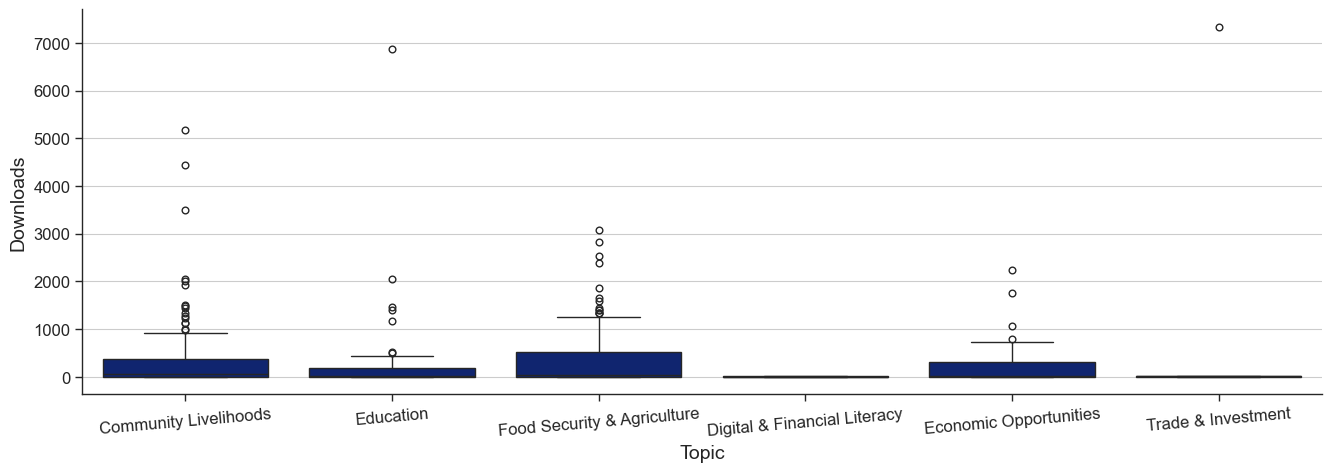

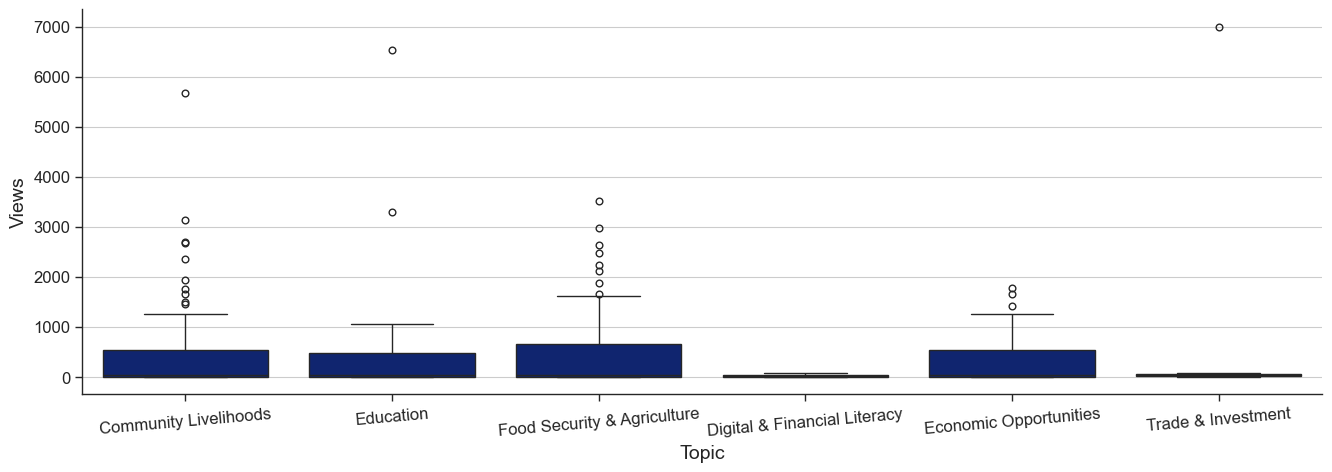

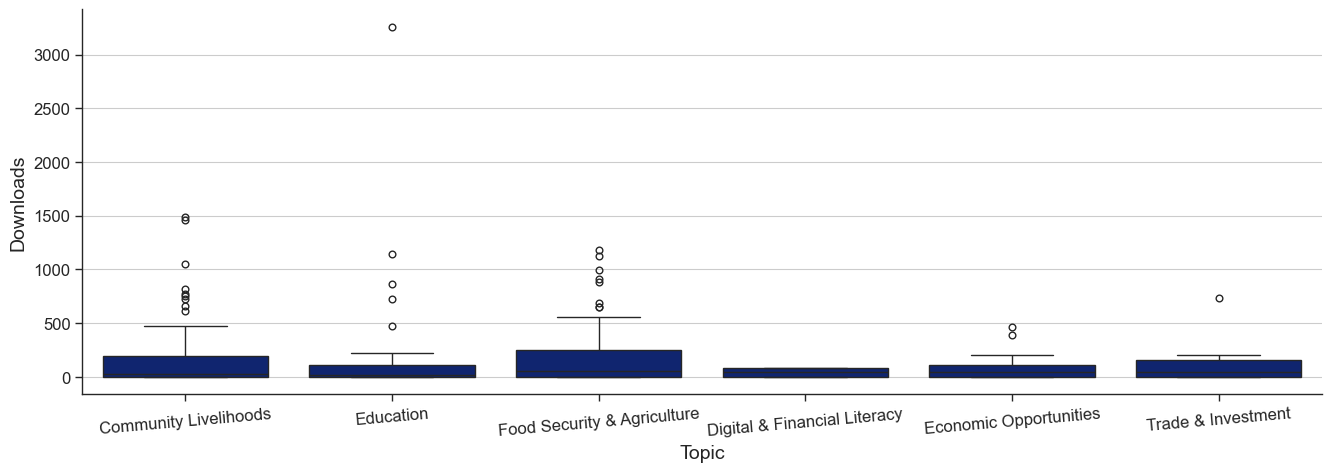

In [10]:
#Subsets of interest: Neliti Downloads, Neliti Views, Website Downloads
#TODO: USE MAX VALUES TO COLLECT LIST OF ALL OUTLIER TITLES

def totalitup(df,click_type):
    categories = df.loc[:,['Source','Click Type','Language','Title','Type','Topic']]
    categories[click_type] = df.iloc[:,6:].sum(axis=1)
    return categories

all_DL = pd.concat([totalitup(eng_DL,'Downloads'),totalitup(ind_DL,'Downloads')],axis=0,ignore_index=True)
all_VIEWS = pd.concat([totalitup(eng_VIEWS,'Views'),totalitup(ind_VIEWS,'Views')],axis=0,ignore_index=True)

neliti_downloads = all_DL.loc[all_DL['Source'] == 'Neliti']
neliti_views = all_VIEWS.loc[all_VIEWS['Source'] == 'Neliti']
website_downloads = all_DL.loc[all_DL['Source'] == 'Website']

def maxvalues(row,df,clicktype):
    quartile_3 = df.loc[df['Topic'] == row][clicktype].quantile(q=0.75,interpolation='linear')
    quartile_1 = df.loc[df['Topic'] == row][clicktype].quantile(q=0.25,interpolation='linear')
    IQR = quartile_3 - quartile_1
    return quartile_3 + (1.5*IQR)


#Neliti downloads vs Topic - ANOVA
#Null hypothesis: Mean downloads across different topics is the same
nel_dl_categories = neliti_downloads.groupby('Topic')['Downloads'].apply(list)
anova_results = stats.f_oneway(*nel_dl_categories)
if anova_results[1] <= 0.05:
    print("The mean downloads across topics ARE significantly different with a p-value of:",anova_results[1])
elif anova_results[1] > 0.05:
    print("The mean downloads across topics are NOT significantly different with a p-value of:",anova_results[1])

plt.figure(figsize=(16,5))
ax = sns.boxplot(data=neliti_downloads,x='Topic',y='Downloads')
ax.set_xticklabels(ax.get_xticklabels(),rotation=5)

max_nel_dl = pd.DataFrame({'Topic':list(set(neliti_downloads['Topic']))})
max_nel_dl['Max Values'] = max_nel_dl['Topic'].apply(maxvalues,args=(neliti_downloads,'Downloads'))


#Neliti views vs Topic - ANOVA
#Null hypothesis: Mean views across different topics is the same
nel_view_categories = neliti_views.groupby('Topic')['Views'].apply(list)
anova_results = stats.f_oneway(*nel_view_categories)
if anova_results[1] <= 0.05:
    print("The mean views across topics ARE significantly different with a p-value of:",anova_results[1])
elif anova_results[1] > 0.05:
    print("The mean views across topics are NOT significantly different with a p-value of:",anova_results[1])
    
plt.figure(figsize=(16,5))
ax = sns.boxplot(data=neliti_views,x='Topic',y='Views')
ax.set_xticklabels(ax.get_xticklabels(),rotation=5)

max_nel_views = pd.DataFrame({'Topic':list(set(neliti_views['Topic']))})
max_nel_views['Max Values'] = max_nel_views['Topic'].apply(maxvalues,args=(neliti_views,'Views'))


#Website downloads vs Topic - ANOVA
#Null hypothesis: Mean downloads across different topics is the same
web_dl_categories = website_downloads.groupby('Topic')['Downloads'].apply(list)
anova_results = stats.f_oneway(*web_dl_categories)
if anova_results[1] <= 0.05:
    print("The mean downloads across topics ARE significantly different with a p-value of:",anova_results[1])
elif anova_results[1] > 0.05:
    print("The mean downloads across topics are NOT significantly different with a p-value of:",anova_results[1])

plt.figure(figsize=(16,5))
ax = sns.boxplot(data=website_downloads,x='Topic',y='Downloads')
ax.set_xticklabels(ax.get_xticklabels(),rotation=5)

max_web_dl = pd.DataFrame({'Topic':list(set(website_downloads['Topic']))})
max_web_dl['Max Values'] = max_web_dl['Topic'].apply(maxvalues,args=(website_downloads,'Downloads'))

In [11]:
#GOOGLE TRENDS KEYWORD ANALYSIS

#Define function for creating list of parsed keywords
def kwsplitter(kw_list):
    #Loops through each row containing a list of keywords then splits the list of keywords based on ', ' and loops through this to return a lower case complete list of all keywords
    full_list = [value.lower() for kw in kw_list for value in kw.split(', ')]
    
    #Returns the keywords as a unique set
    return set(full_list)

#Split keywords into two lists containing Indonesian & English keywords respectively based on the 'Keyword Language' column
#Filter removes the empty elements from the list which is then converted to a list using list()
eng_kw = list(filter(None,kwsplitter(df.loc[df['Keyword Language'] == 'English','Keywords'].tolist())))
ind_kw = list(filter(None,kwsplitter(df.loc[df['Keyword Language'] == 'Indonesian','Keywords'].tolist())))

#Connect to pytrends for English and Indonesian search data
engtrends = TrendReq(hl='en-US',tz=420)
indtrends = TrendReq(hl='id',tz=420)

#Define function for returning Google search popularity of keywords
def gtrends_over_time(kw_list,ref_word,searchlang):
    #Uses the search language parameter of the function to specify the language and timezone of the search data
    if searchlang == 'English':
        trend = engtrends
    elif searchlang == 'Indonesian':
        trend = indtrends
    
    #Initialise empty dataframe and loop counter then begins while loop to run for the length of the keyword list
    trend_df = pd.DataFrame()
    i = 0
    while i < len(kw_list):
        #Slices keyword list based on loop counter and appends the reference word
        l = kw_list[i:(i+4)]
        l.append(ref_word)
        
        #Creates pytrends payload specifying timeframe and geographical region. Assigns result of interest over time to the result variable
        trend.build_payload(l,timeframe='all',geo='ID')
        result = trend.interest_over_time()
        
        #Resets result index and renames duplicate columns
        result.reset_index(inplace=True)
        result.rename(columns={'isPartial':'isPartial'+str(i),ref_word:ref_word+str(i)},inplace=True)
        
        #If first loop, adds result of query to the trend_df dataframe. Second elif statement works because the number of rows stays the same each iteration (number of date entries)
        if len(trend_df.index) == 0:
            trend_df = pd.concat([trend_df,result])
        elif len(trend_df.index) == len(result):
            trend_df = pd.merge(trend_df,result,on='date')
        
        #Adds to loop counter (4 search keywords + 1 reference keyword)
        i += 4
    
    #Return resulting dataframe
    return trend_df

NameError: name 'df' is not defined